In [ ]:
!pip install ultralytics
!pip install roboflow  # Optional: if you want to use roboflow utilities
!pip install pandas matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
import torch
import time
import numpy as np
from pathlib import Path
import shutil



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {torch.cuda.get_device_name() if torch.cuda.is_available() else 'CPU'}")


CUDA available: True
Device: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted successfully!")
print("Please provide the path to your dataset in Google Drive")


Mounted at /content/drive
Google Drive mounted successfully!
Please provide the path to your dataset in Google Drive


In [ ]:
DATASET_ZIP_PATH = '/content/drive/MyDrive/yolov11dataset.zip'
USE_ZIP_FILE = True  # Set to True if using zip file, False if using folder

if USE_ZIP_FILE:
    # Extract zip file from Google Drive
    import zipfile
    if os.path.exists(DATASET_ZIP_PATH):
        print(f"Found dataset zip file: {DATASET_ZIP_PATH}")
        with zipfile.ZipFile(DATASET_ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall('/content/dataset')
        print(f"Extracted dataset to /content/dataset")
    else:
        print(f"Error: Dataset zip file not found at {DATASET_ZIP_PATH}")
        print("Please update DATASET_ZIP_PATH with the correct path")

else:
    # Copy dataset folder from Google Drive
    if os.path.exists(DATASET_FOLDER_PATH):
        print(f"Found dataset folder: {DATASET_FOLDER_PATH}")
        import shutil
        shutil.copytree(DATASET_FOLDER_PATH, '/content/dataset')
        print(f"Copied dataset to /content/dataset")
    else:
        print(f"Error: Dataset folder not found at {DATASET_FOLDER_PATH}")
        print("Please update DATASET_FOLDER_PATH with the correct path")





Found dataset zip file: /content/drive/MyDrive/yolov11dataset.zip
Extracted dataset to /content/dataset


In [ ]:
def check_dataset_structure(base_path):
    """Check if dataset has proper YOLOv8 structure"""
    base_path = Path(base_path)

    required_dirs = ['train/images', 'train/labels', 'val/images', 'val/labels']
    optional_dirs = ['test/images', 'test/labels']

    print("Checking dataset structure...")
    for dir_path in required_dirs:
        full_path = base_path / dir_path
        if full_path.exists():
            count = len(list(full_path.glob('*')))
            print(f"✓ {dir_path}: {count} files")
        else:
            print(f"✗ {dir_path}: Missing!")

    for dir_path in optional_dirs:
        full_path = base_path / dir_path
        if full_path.exists():
            count = len(list(full_path.glob('*')))
            print(f"✓ {dir_path}: {count} files")
        else:
            print(f"○ {dir_path}: Not found (optional)")

# Check your dataset
check_dataset_structure('/content/dataset')

Checking dataset structure...
✗ train/images: Missing!
✗ train/labels: Missing!
✗ val/images: Missing!
✗ val/labels: Missing!
○ test/images: Not found (optional)
○ test/labels: Not found (optional)


In [ ]:
def explore_dataset_structure(base_path, max_depth=3):
    """Explore and display the actual dataset structure"""
    base_path = Path(base_path)

    print(f"\n🔍 Exploring dataset structure in: {base_path}")
    print("="*50)

    if not base_path.exists():
        print(f"❌ Path does not exist: {base_path}")
        return

    def print_tree(path, prefix="", depth=0):
        if depth > max_depth:
            return

        items = list(path.iterdir())
        items.sort(key=lambda x: (x.is_file(), x.name.lower()))

        for i, item in enumerate(items):
            is_last = i == len(items) - 1
            current_prefix = "└── " if is_last else "├── "
            print(f"{prefix}{current_prefix}{item.name}")

            if item.is_dir() and depth < max_depth:
                extension_prefix = "    " if is_last else "│   "
                print_tree(item, prefix + extension_prefix, depth + 1)

    print_tree(base_path)

    # Count files by extension
    all_files = list(base_path.rglob('*'))
    file_types = {}

    for file_path in all_files:
        if file_path.is_file():
            ext = file_path.suffix.lower()
            file_types[ext] = file_types.get(ext, 0) + 1

    print(f"\n📊 File type summary:")
    for ext, count in sorted(file_types.items()):
        print(f"   {ext if ext else 'no extension'}: {count} files")

# Explore the actual structure
explore_dataset_structure('/content/dataset')

# ==========================================
# STEP 3.2: Auto-Fix Dataset Structure
# ==========================================

def auto_fix_dataset_structure(base_path):
    """Automatically detect and fix common dataset structure issues"""
    base_path = Path(base_path)

    print(f"\n🔧 Attempting to auto-fix dataset structure...")

    # Common patterns in Label Studio exports
    possible_patterns = [
        # Pattern 1: Direct images and labels in root
        {'images': base_path.glob('*.jpg'), 'labels': base_path.glob('*.txt')},
        {'images': base_path.glob('*.png'), 'labels': base_path.glob('*.txt')},
        {'images': base_path.glob('*.jpeg'), 'labels': base_path.glob('*.txt')},

        # Pattern 2: Images and labels in separate folders
        {'images': (base_path / 'images').glob('*') if (base_path / 'images').exists() else [],
         'labels': (base_path / 'labels').glob('*') if (base_path / 'labels').exists() else []},

        # Pattern 3: All files mixed in a single folder
        {'images': base_path.rglob('*.jpg'), 'labels': base_path.rglob('*.txt')},
        {'images': base_path.rglob('*.png'), 'labels': base_path.rglob('*.txt')},
        {'images': base_path.rglob('*.jpeg'), 'labels': base_path.rglob('*.txt')},
    ]

    # Find all image and label files
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    all_images = []
    all_labels = []

    for file_path in base_path.rglob('*'):
        if file_path.is_file():
            if file_path.suffix.lower() in image_extensions:
                all_images.append(file_path)
            elif file_path.suffix.lower() == '.txt' and file_path.name != 'classes.txt':
                all_labels.append(file_path)

    print(f"Found {len(all_images)} images and {len(all_labels)} label files")

    if len(all_images) == 0:
        print("❌ No images found! Please check your dataset.")
        return False

    # Create proper YOLOv8 structure
    train_images_dir = base_path / 'train' / 'images'
    train_labels_dir = base_path / 'train' / 'labels'
    val_images_dir = base_path / 'val' / 'images'
    val_labels_dir = base_path / 'val' / 'labels'

    # Create directories
    for dir_path in [train_images_dir, train_labels_dir, val_images_dir, val_labels_dir]:
        dir_path.mkdir(parents=True, exist_ok=True)

    # Split data (80% train, 20% val)
    import random
    random.shuffle(all_images)

    split_idx = int(0.8 * len(all_images))
    train_images = all_images[:split_idx]
    val_images = all_images[split_idx:]

    print(f"Splitting dataset: {len(train_images)} training, {len(val_images)} validation")

    # Copy files to proper structure
    def copy_image_and_label(image_path, dest_images_dir, dest_labels_dir):
        """Copy image and its corresponding label file"""
        # Copy image
        new_image_path = dest_images_dir / image_path.name
        shutil.copy2(image_path, new_image_path)

        # Find and copy corresponding label
        label_name = image_path.stem + '.txt'

        # Look for label file in various locations
        possible_label_paths = [
            image_path.parent / label_name,  # Same directory as image
            base_path / 'labels' / label_name,  # In labels folder
            base_path / label_name,  # In root
        ]

        # Also search recursively
        for label_path in base_path.rglob(label_name):
            if label_path.is_file():
                possible_label_paths.append(label_path)

        label_copied = False
        for label_path in possible_label_paths:
            if label_path.exists():
                new_label_path = dest_labels_dir / label_name
                shutil.copy2(label_path, new_label_path)
                label_copied = True
                break

        if not label_copied:
            # Create empty label file if not found
            empty_label_path = dest_labels_dir / label_name
            empty_label_path.touch()
            print(f"⚠️  Created empty label file for {image_path.name}")

    # Copy training files
    print("Copying training files...")
    for img_path in train_images:
        copy_image_and_label(img_path, train_images_dir, train_labels_dir)

    # Copy validation files
    print("Copying validation files...")
    for img_path in val_images:
        copy_image_and_label(img_path, val_images_dir, val_labels_dir)

    print("✅ Dataset structure fixed!")
    return True

# Attempt to auto-fix the structure
if auto_fix_dataset_structure('/content/dataset'):
    print("\n🔄 Re-checking dataset structure after auto-fix...")
    check_dataset_structure('/content/dataset')
else:
    print("\n❌ Could not auto-fix dataset structure. Manual intervention required.")

    # Show manual instructions
    print("\n📝 Manual Fix Instructions:")
    print("1. Check the actual structure shown above")
    print("2. Organize your files into this structure:")
    print("   /content/dataset/")
    print("   ├── train/")
    print("   │   ├── images/")
    print("   │   └── labels/")
    print("   ├── val/")
    print("   │   ├── images/")
    print("   │   └── labels/")
    print("   └── data.yaml")
    print("3. Re-run the dataset structure check")


🔍 Exploring dataset structure in: /content/dataset
├── images
│   ├── 002efb9b-Greenverz_Nilgai_001.jpg
│   ├── 003438e5-9e35aa0d71.jpg
│   ├── 004274ec-04c289fef9aeb1c8ca90690bd5c5e72a.jpg
│   ├── 0064eb2d-8c6a936c9a.jpg
│   ├── 0075da85-bengal-cooch-behar-bengal-fox-scratching-ripan-biswas-1692604379912.jpg
│   ├── 009c7745-Felis-Lineage-African-Asiatic-Wildcat-slide-v2.jpg
│   ├── 010e20cd-6c9f856e4d86097eeb2a3652483b8536.jpg
│   ├── 01111eb8-2.jpg
│   ├── 0131d4b6-634e360e94343b73cc1ae456-collecta-nilgai-animal-toy.jpg
│   ├── 014cd4c1-30cc4e89b6.jpg
│   ├── 014db6ea-53257534059_ab2331a881_b.jpg
│   ├── 015b8f28-Lion-Cheetah-Infographic-2-V1-050822-CI.jpg
│   ├── 016fbabf-75e03d47d7.jpg
│   ├── 0182abef-image23.jpeg
│   ├── 019cb705-honey-badger-2.jpg
│   ├── 01c073cb-358126-358048-nilgai-trouble-bihar-farmers-crops-devastation-farmers-p_AgqqTLL.jpg
│   ├── 01d498b6-nilgai-antelope_1.jpg
│   ├── 01dcffa4-5ca842321d.jpg
│   ├── 021c338d-Ruddy_mongoose__Herpestes_smithii.png
│   ├──

In [ ]:
def create_data_yaml(dataset_path, class_names):
    """Create data.yaml file for YOLOv11 training"""

    data_yaml_content = {
        'path': dataset_path,  # Dataset root dir
        'train': 'train/images',  # Train images relative to 'path'
        'val': 'val/images',      # Val images relative to 'path'
        'test': 'test/images',    # Test images relative to 'path' (optional)
        'nc': len(class_names),   # Number of classes
        'names': class_names      # Class names
    }

    yaml_path = os.path.join(dataset_path, 'data.yaml')
    with open(yaml_path, 'w') as f:
        yaml.dump(data_yaml_content, f, default_flow_style=False)

    print(f"Created data.yaml at {yaml_path}")
    return yaml_path

# Example: Define your class names (modify according to your dataset)
# You can find class names from your Label Studio export or existing data.yaml
CLASS_NAMES = ['Domestic Animal','No Animal','wild Animal']  # MODIFY THIS with your actual class names

# If you already have data.yaml, you can read it to get class names
dataset_yaml_path = '/content/dataset/data.yaml'
if os.path.exists(dataset_yaml_path):
    with open(dataset_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
    CLASS_NAMES = data_config['names']
    print(f"Found existing data.yaml with classes: {CLASS_NAMES}")
else:
    # Create new data.yaml
    dataset_yaml_path = create_data_yaml('/content/dataset', CLASS_NAMES)

# Update the yaml file to use absolute paths
with open(dataset_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

data_config['path'] = '/content/dataset'
data_config['train'] = 'train/images'
data_config['val'] = 'val/images'
if os.path.exists('/content/dataset/test/images'):
    data_config['test'] = 'test/images'

with open(dataset_yaml_path, 'w') as f:
    yaml.dump(data_config, f, default_flow_style=False)

print("Updated data.yaml with correct paths")

Found existing data.yaml with classes: ['class1', 'class2', 'class3']
Updated data.yaml with correct paths


In [ ]:
model_size = 'yolo11s'  # Change this if you want different model size
model = YOLO(f'{model_size}.pt')

print(f"Loaded {model_size} model")

100%|██████████| 18.4M/18.4M [00:00<00:00, 258MB/s]

Loaded yolo11s model


In [ ]:
EPOCHS = 100  # Adjust based on your needs
BATCH_SIZE = 16  # Adjust based on your GPU memory
IMG_SIZE = 640  # Image size for training

# Start training
print("Starting training...")
results = model.train(
    data=dataset_yaml_path,
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    imgsz=IMG_SIZE,
    device=0 if torch.cuda.is_available() else 'cpu',
    project='/content/runs/detect',
    name='yolov11_training',
    save_period=10,  # Save checkpoint every 10 epochs
    patience=20,     # Early stopping patience
    verbose=True,
    plots=True       # Generate training plots
)

print("Training completed!")

Starting training...
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11_training, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=

100%|██████████| 755k/755k [00:00<00:00, 21.6MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

 22                  -1  1   1511424  ultralytics.nn.modules.block.C3k2            [768, 512, 1, True]           
 23        [16, 19, 22]  1    820569  ultralytics.nn.modules.head.Detect           [3, [128, 256, 512]]          
YOLO11s summary: 181 layers, 9,428,953 parameters, 9,428,937 gradients, 21.6 GFLOPs

Transferred 493/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 86.2MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 853.4±485.4 MB/s, size: 81.2 KB)


train: Scanning /content/dataset/train/labels... 1612 images, 7 backgrounds, 4 corrupt: 100%|██████████| 1612/1612 [00:01<00:00, 1381.52it/s]

train: /content/dataset/train/images/29866319-A-and-B-Minor-injuries-sustained-by-Mugger-Crocodiles-Crocodylus-palus_s7XVAgH.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.898]
train: /content/dataset/train/images/6deaefc1-800px-Fourhornedantelope.JPG.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2001]
train: /content/dataset/train/images/70d3098d-01345311.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.009]
train: /content/dataset/train/images/cae75177-Four_horned_antelope.jpg: corrupt JPEG restored and saved
train: /content/dataset/train/images/fd43b321-30d3c289d7.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2023]
train: New cache created: /content/dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 548.5±474.6 MB/s, size: 120.3 KB)


val: Scanning /content/dataset/val/labels... 404 images, 0 backgrounds, 1 corrupt: 100%|██████████| 404/404 [00:00<00:00, 869.41it/s]

val: /content/dataset/val/images/7ab0c269-ghnewsok-OK-3391446-16d29d07.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0078]
val: New cache created: /content/dataset/val/labels.cache


Plotting labels to /content/runs/detect/yolov11_training/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/runs/detect/yolov11_training
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.01G      1.098      1.794      1.447         25        640: 100%|██████████| 101/101 [00:50<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.98it/s]

                   all        403        610      0.344      0.464      0.338       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.27G      1.305      1.545      1.593         42        640: 100%|██████████| 101/101 [00:43<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]

                   all        403        610      0.273      0.402      0.262      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.31G      1.374      1.582      1.668         28        640: 100%|██████████| 101/101 [00:43<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]

                   all        403        610      0.311      0.359       0.23     0.0956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.35G      1.379      1.629      1.664         26        640: 100%|██████████| 101/101 [00:41<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]

                   all        403        610      0.383      0.531      0.418      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.39G      1.317      1.529       1.62         53        640: 100%|██████████| 101/101 [00:41<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]

                   all        403        610      0.517      0.447      0.424      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.41G      1.262       1.47      1.572         23        640: 100%|██████████| 101/101 [00:41<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.60it/s]

                   all        403        610      0.579      0.493      0.504      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.47G      1.255      1.428      1.561         20        640: 100%|██████████| 101/101 [00:41<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]

                   all        403        610      0.278      0.329       0.24      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.51G      1.211      1.364      1.539         26        640: 100%|██████████| 101/101 [00:42<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]

                   all        403        610      0.522      0.574      0.528      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.55G      1.198      1.352      1.525         13        640: 100%|██████████| 101/101 [00:42<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]

                   all        403        610      0.653      0.506      0.562      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.57G      1.166        1.3      1.497         32        640: 100%|██████████| 101/101 [00:41<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]

                   all        403        610       0.57      0.533      0.555       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.63G      1.175      1.291      1.492         25        640: 100%|██████████| 101/101 [00:42<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]

                   all        403        610      0.794      0.337      0.439      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.67G      1.125      1.228      1.464         33        640: 100%|██████████| 101/101 [00:41<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]

                   all        403        610      0.543      0.606      0.574      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.71G      1.101      1.228      1.447         28        640: 100%|██████████| 101/101 [00:41<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.40it/s]

                   all        403        610      0.681      0.615      0.643      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.73G      1.114      1.199      1.458         30        640: 100%|██████████| 101/101 [00:41<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]

                   all        403        610      0.573      0.635      0.613      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.79G      1.114      1.198      1.451         27        640: 100%|██████████| 101/101 [00:41<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]

                   all        403        610      0.576      0.595      0.614      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.83G      1.052      1.152      1.404         27        640: 100%|██████████| 101/101 [00:41<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.32it/s]

                   all        403        610      0.739      0.637      0.695      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.87G      1.047      1.122      1.407         23        640: 100%|██████████| 101/101 [00:42<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]

                   all        403        610      0.691      0.628      0.691      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.89G      1.054      1.119      1.408         17        640: 100%|██████████| 101/101 [00:42<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.42it/s]

                   all        403        610       0.65      0.657      0.649      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.94G      1.047      1.129      1.413         26        640: 100%|██████████| 101/101 [00:42<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]

                   all        403        610      0.682      0.626      0.676      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.99G      1.035      1.103      1.398         31        640: 100%|██████████| 101/101 [00:41<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


                   all        403        610      0.674       0.64      0.677       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.02G      1.035      1.061      1.382         17        640: 100%|██████████| 101/101 [00:41<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]

                   all        403        610      0.692      0.674      0.704      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.04G      1.021      1.056      1.371         25        640: 100%|██████████| 101/101 [00:41<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.32it/s]

                   all        403        610      0.759      0.693      0.748      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       6.1G     0.9961      1.042      1.365         27        640: 100%|██████████| 101/101 [00:41<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]

                   all        403        610      0.802      0.678      0.761      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.14G     0.9964       1.05      1.354         37        640: 100%|██████████| 101/101 [00:41<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]

                   all        403        610      0.796      0.723      0.778      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.18G     0.9658      1.009      1.352         32        640: 100%|██████████| 101/101 [00:42<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]

                   all        403        610      0.657      0.707      0.716      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       6.2G       1.01      1.031      1.373         31        640: 100%|██████████| 101/101 [00:42<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]

                   all        403        610      0.771      0.717      0.788      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.26G     0.9834      1.007      1.353         31        640: 100%|██████████| 101/101 [00:41<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.68it/s]

                   all        403        610      0.774      0.718      0.765      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       6.3G     0.9693     0.9882      1.341         34        640: 100%|██████████| 101/101 [00:42<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.23it/s]

                   all        403        610      0.797      0.695      0.777      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.34G     0.9547     0.9712      1.323         35        640: 100%|██████████| 101/101 [00:40<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]

                   all        403        610      0.692      0.706      0.762      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.36G      0.945     0.9527      1.327         25        640: 100%|██████████| 101/101 [00:41<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


                   all        403        610      0.808      0.709      0.799      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.42G     0.9172     0.9249       1.31         38        640: 100%|██████████| 101/101 [00:41<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]

                   all        403        610      0.758      0.699      0.764      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.46G     0.9289     0.9233      1.312         22        640: 100%|██████████| 101/101 [00:41<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.45it/s]

                   all        403        610      0.747      0.693      0.758      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       6.5G      0.957     0.9478      1.325         24        640: 100%|██████████| 101/101 [00:41<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.04it/s]

                   all        403        610      0.832       0.72      0.817      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.52G     0.9443     0.8823      1.316         25        640: 100%|██████████| 101/101 [00:41<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]

                   all        403        610      0.794      0.731      0.801      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.58G     0.9309     0.8995        1.3         23        640: 100%|██████████| 101/101 [00:41<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.69it/s]

                   all        403        610      0.688      0.689      0.753      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.62G     0.9307     0.8914      1.311         33        640: 100%|██████████| 101/101 [00:41<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]

                   all        403        610      0.784      0.741      0.803      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.66G     0.9111      0.873      1.294         37        640: 100%|██████████| 101/101 [00:41<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.64it/s]

                   all        403        610      0.779      0.709      0.775      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.68G     0.8779      0.848      1.273         43        640: 100%|██████████| 101/101 [00:41<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.13it/s]

                   all        403        610      0.819      0.738      0.817      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.74G     0.9007     0.8638       1.29         29        640: 100%|██████████| 101/101 [00:41<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]

                   all        403        610      0.856      0.732      0.831      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.78G     0.8905     0.8534      1.288         23        640: 100%|██████████| 101/101 [00:41<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


                   all        403        610      0.779      0.723      0.809      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.82G     0.8863     0.8308      1.284         20        640: 100%|██████████| 101/101 [00:40<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]

                   all        403        610      0.832      0.739      0.807      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.84G     0.8832      0.826      1.275         29        640: 100%|██████████| 101/101 [00:42<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]

                   all        403        610      0.831      0.745      0.829      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       6.9G     0.8663     0.8044      1.259         23        640: 100%|██████████| 101/101 [00:41<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.96it/s]

                   all        403        610      0.799      0.713      0.782      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.94G     0.8891     0.8381      1.278         21        640: 100%|██████████| 101/101 [00:40<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.34it/s]

                   all        403        610      0.843      0.748      0.843      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.98G     0.8526        0.8      1.247         28        640: 100%|██████████| 101/101 [00:42<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.33it/s]

                   all        403        610      0.865      0.743      0.835      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         7G     0.8582     0.7779      1.252         25        640: 100%|██████████| 101/101 [00:41<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]

                   all        403        610      0.806      0.754      0.827      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.06G      0.857     0.8027      1.259         30        640: 100%|██████████| 101/101 [00:41<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]

                   all        403        610      0.793      0.722       0.81      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       7.1G     0.8497     0.7811      1.255         25        640: 100%|██████████| 101/101 [00:42<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]

                   all        403        610       0.86      0.756      0.843      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      7.14G     0.8378     0.7692      1.246         33        640: 100%|██████████| 101/101 [00:41<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]

                   all        403        610      0.867      0.771       0.85      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      7.16G     0.8386      0.764      1.244         24        640: 100%|██████████| 101/101 [00:41<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.37it/s]

                   all        403        610      0.825      0.755      0.845      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      7.22G      0.822     0.7384      1.228         30        640: 100%|██████████| 101/101 [00:41<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.09it/s]

                   all        403        610      0.802      0.772      0.847      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      7.26G     0.8273      0.735      1.231         31        640: 100%|██████████| 101/101 [00:42<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


                   all        403        610      0.813      0.792      0.841      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       7.3G     0.8108     0.7314       1.23         38        640: 100%|██████████| 101/101 [00:40<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]

                   all        403        610      0.813      0.768       0.83      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.32G     0.8311     0.7204      1.228         29        640: 100%|██████████| 101/101 [00:42<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]

                   all        403        610       0.87      0.781      0.873      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      7.38G     0.8096     0.7038      1.219         27        640: 100%|██████████| 101/101 [00:42<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]

                   all        403        610      0.853      0.723       0.83      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.31G      0.823     0.7269      1.228         26        640: 100%|██████████| 101/101 [00:41<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.19it/s]

                   all        403        610      0.858       0.78      0.859      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.31G      0.795     0.7099       1.21         19        640: 100%|██████████| 101/101 [00:41<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]

                   all        403        610      0.855      0.787      0.855      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.31G       0.78     0.6896      1.199         17        640: 100%|██████████| 101/101 [00:41<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]

                   all        403        610      0.913      0.737      0.858      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.31G     0.7906     0.7105      1.214         24        640: 100%|██████████| 101/101 [00:42<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.41it/s]

                   all        403        610      0.895      0.765      0.865      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.31G     0.7851     0.6923      1.202         28        640: 100%|██████████| 101/101 [00:41<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]

                   all        403        610      0.859      0.783      0.861      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.31G     0.7741     0.6717      1.203         32        640: 100%|██████████| 101/101 [00:42<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]

                   all        403        610      0.897      0.768      0.873      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.33G     0.7718     0.6879      1.205         27        640: 100%|██████████| 101/101 [00:42<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]

                   all        403        610      0.873      0.772      0.856      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.39G     0.7732     0.6611      1.199         33        640: 100%|██████████| 101/101 [00:42<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.60it/s]

                   all        403        610      0.878      0.802      0.863       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.43G     0.7892     0.6498      1.191         34        640: 100%|██████████| 101/101 [00:42<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.48it/s]

                   all        403        610      0.904      0.751      0.853      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.47G      0.757     0.6355      1.179         28        640: 100%|██████████| 101/101 [00:41<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]

                   all        403        610      0.884      0.782      0.873      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.49G     0.7702     0.6522      1.187         47        640: 100%|██████████| 101/101 [00:41<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


                   all        403        610      0.877      0.766      0.854       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.55G     0.7661      0.648      1.184         26        640: 100%|██████████| 101/101 [00:42<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.00it/s]

                   all        403        610      0.933      0.729      0.868      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.59G     0.7444     0.6211      1.172         36        640: 100%|██████████| 101/101 [00:42<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]

                   all        403        610      0.918       0.78       0.88      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.63G     0.7562     0.6367      1.169         28        640: 100%|██████████| 101/101 [00:42<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

                   all        403        610      0.845      0.798       0.87      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.65G     0.7461     0.6272      1.176         33        640: 100%|██████████| 101/101 [00:41<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.06it/s]

                   all        403        610      0.887      0.787      0.879      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.76G     0.7396     0.6051      1.163         27        640: 100%|██████████| 101/101 [00:42<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.43it/s]

                   all        403        610      0.885      0.813      0.886      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       4.8G     0.7528      0.629       1.19         15        640: 100%|██████████| 101/101 [00:41<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]

                   all        403        610       0.88      0.783       0.87      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.84G     0.7189     0.6027      1.152         37        640: 100%|██████████| 101/101 [00:41<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.65it/s]

                   all        403        610      0.825      0.796      0.867      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       4.9G     0.7226      0.584       1.16         17        640: 100%|██████████| 101/101 [00:41<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

                   all        403        610      0.879      0.801      0.869      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.96G     0.7297     0.6146      1.162         26        640: 100%|██████████| 101/101 [00:40<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.97it/s]

                   all        403        610       0.86      0.795      0.872      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         5G     0.7229      0.596      1.155         23        640: 100%|██████████| 101/101 [00:41<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]

                   all        403        610      0.912      0.769      0.874      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.04G     0.7265     0.5868      1.153         19        640: 100%|██████████| 101/101 [00:43<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]

                   all        403        610       0.85      0.814      0.877      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       5.1G     0.7161      0.589       1.16         27        640: 100%|██████████| 101/101 [00:43<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]

                   all        403        610      0.835      0.779      0.863      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.16G     0.7112     0.5709      1.139         25        640: 100%|██████████| 101/101 [00:42<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]

                   all        403        610      0.884      0.764      0.865      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.52G     0.6966     0.5569      1.147         29        640: 100%|██████████| 101/101 [00:42<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.06it/s]

                   all        403        610      0.873      0.782      0.872      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.56G     0.7028     0.5599      1.137         17        640: 100%|██████████| 101/101 [00:42<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.22it/s]

                   all        403        610      0.905      0.748      0.862      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.58G     0.6978     0.5466      1.141         27        640: 100%|██████████| 101/101 [00:41<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.01it/s]

                   all        403        610      0.846      0.799      0.866      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.64G     0.6881     0.5569      1.132         36        640: 100%|██████████| 101/101 [00:41<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.28it/s]

                   all        403        610      0.902      0.781      0.878      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.68G     0.6764     0.5363      1.133         18        640: 100%|██████████| 101/101 [00:41<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]

                   all        403        610      0.883      0.803      0.873      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.72G     0.6856     0.5553      1.127         23        640: 100%|██████████| 101/101 [00:42<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]

                   all        403        610      0.889      0.784      0.874      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.74G     0.6855     0.5522      1.132         25        640: 100%|██████████| 101/101 [00:42<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.16it/s]

                   all        403        610      0.844      0.826      0.888      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       5.8G       0.67     0.5308      1.118         31        640: 100%|██████████| 101/101 [00:42<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]

                   all        403        610      0.913      0.767      0.886      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.84G     0.6641     0.5271      1.121         30        640: 100%|██████████| 101/101 [00:42<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]

                   all        403        610       0.87      0.799      0.876      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.88G     0.6579      0.522      1.111         25        640: 100%|██████████| 101/101 [00:41<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]

                   all        403        610      0.901       0.77      0.871      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       5.9G     0.6699     0.5238      1.123         23        640: 100%|██████████| 101/101 [00:42<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  2.62it/s]

                   all        403        610      0.864      0.825      0.884      0.688


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.96G     0.5741     0.4087      1.084         10        640: 100%|██████████| 101/101 [00:43<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]

                   all        403        610      0.911      0.753      0.856      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         6G     0.5427     0.3474      1.049          8        640: 100%|██████████| 101/101 [00:41<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]

                   all        403        610      0.913      0.751      0.868      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.04G     0.5325      0.344      1.038         14        640: 100%|██████████| 101/101 [00:41<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.05it/s]

                   all        403        610      0.892      0.787      0.872       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.06G     0.5172     0.3245      1.031         11        640: 100%|██████████| 101/101 [00:40<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]

                   all        403        610      0.897      0.779      0.871      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.12G     0.5196     0.3291      1.027          8        640: 100%|██████████| 101/101 [00:41<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.34it/s]

                   all        403        610      0.922      0.779      0.881      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.16G     0.5043     0.3171      1.028          9        640: 100%|██████████| 101/101 [00:40<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  1.95it/s]

                   all        403        610      0.886      0.789      0.872      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       6.2G     0.5139       0.32      1.033         10        640: 100%|██████████| 101/101 [00:40<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]

                   all        403        610      0.873      0.799      0.876      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.22G     0.5112     0.3128      1.022          8        640: 100%|██████████| 101/101 [00:41<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]

                   all        403        610      0.931      0.787      0.883      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.28G     0.4973       0.31      1.016         10        640: 100%|██████████| 101/101 [00:40<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.11it/s]

                   all        403        610      0.933      0.792      0.877      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.32G     0.4865     0.3043      1.004          9        640: 100%|██████████| 101/101 [00:40<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:06<00:00,  2.10it/s]

                   all        403        610      0.923      0.792      0.881      0.689



100 epochs completed in 1.362 hours.
Optimizer stripped from /content/runs/detect/yolov11_training/weights/last.pt, 19.2MB
Optimizer stripped from /content/runs/detect/yolov11_training/weights/best.pt, 19.2MB

Validating /content/runs/detect/yolov11_training/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


                   all        403        610      0.932      0.787      0.883      0.692
                class1        115        185      0.933      0.757      0.882       0.67
                class3        288        425      0.931      0.816      0.885      0.714
Speed: 0.6ms preprocess, 3.6ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to /content/runs/detect/yolov11_training
Training completed!


In [ ]:
best_model_path = '/content/runs/detect/yolov11_training/weights/best.pt'
model = YOLO(best_model_path)

print(f"Loaded best model from {best_model_path}")

Loaded best model from /content/runs/detect/yolov11_training/weights/best.pt


In [ ]:
def evaluate_model_comprehensive(model, test_images_path, test_labels_path):
    """
    Comprehensive evaluation including accuracy, precision, recall, F1, IoU, and inference time
    """

    # Get all test images
    test_images = list(Path(test_images_path).glob('*'))
    if not test_images:
        print("No test images found!")
        return None

    print(f"Found {len(test_images)} test images")

    # Initialize metrics storage
    all_precisions = []
    all_recalls = []
    all_f1_scores = []
    all_ious = []
    inference_times = []

    total_predictions = 0
    correct_predictions = 0

    # Process each test image
    for img_path in test_images:
        # Record inference time
        start_time = time.time()
        results = model(str(img_path), verbose=False)
        end_time = time.time()

        inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
        inference_times.append(inference_time)

        # Get predictions
        result = results[0]

        # Extract metrics from results
        if hasattr(result, 'boxes') and result.boxes is not None:
            boxes = result.boxes
            if len(boxes) > 0:
                # Get confidence scores, classes, and coordinates
                confidences = boxes.conf.cpu().numpy()
                classes = boxes.cls.cpu().numpy()
                coordinates = boxes.xyxy.cpu().numpy()

                # For each detection, we'll consider it correct if confidence > threshold
                confidence_threshold = 0.5
                for conf in confidences:
                    total_predictions += 1
                    if conf > confidence_threshold:
                        correct_predictions += 1

    # Calculate overall accuracy
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

    # Get validation metrics from the model (these are more accurate)
    val_results = model.val(data=dataset_yaml_path, verbose=False)

    # Extract metrics
    metrics = {
        'accuracy': accuracy,
        'precision': float(val_results.box.mp),  # Mean precision
        'recall': float(val_results.box.mr),     # Mean recall
        'f1_score': 2 * (float(val_results.box.mp) * float(val_results.box.mr)) / (float(val_results.box.mp) + float(val_results.box.mr)) if (float(val_results.box.mp) + float(val_results.box.mr)) > 0 else 0,
        'mAP50': float(val_results.box.map50),   # mAP at IoU=0.5
        'mAP50_95': float(val_results.box.map),  # mAP at IoU=0.5:0.95
        'avg_inference_time_ms': np.mean(inference_times),
        'total_test_images': len(test_images),
        'total_inference_time_ms': sum(inference_times)
    }

    return metrics, val_results


In [ ]:
print("\n📊 EVALUATION STRATEGY:")
if os.path.exists('/content/dataset/test/images'):
    print("✓ Test set found - Using dedicated test set for evaluation")
    eval_images_path = '/content/dataset/test/images'
    eval_labels_path = '/content/dataset/test/labels'
    eval_set_name = "Test Set"
else:
    print("ℹ️  No test set found - Using validation set for evaluation")
    print("   This is acceptable practice when no separate test set is available")
    eval_images_path = '/content/dataset/val/images'
    eval_labels_path = '/content/dataset/val/labels'
    eval_set_name = "Validation Set"

# Count evaluation samples
eval_image_count = len(list(Path(eval_images_path).glob('*')))
print(f"📈 Evaluating on {eval_set_name}: {eval_image_count} images")

# Run comprehensive evaluation
print(f"\n🔄 Running evaluation on {eval_set_name.lower()}...")
test_metrics, val_results = evaluate_model_comprehensive(
    model,
    eval_images_path,
    eval_labels_path
)

# Update metrics with evaluation set info
if test_metrics:
    test_metrics['evaluation_set'] = eval_set_name
    test_metrics['evaluation_images'] = eval_image_count


📊 EVALUATION STRATEGY:
ℹ️  No test set found - Using validation set for evaluation
   This is acceptable practice when no separate test set is available
📈 Evaluating on Validation Set: 404 images

🔄 Running evaluation on validation set...
Found 404 test images
Ultralytics 8.3.155 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2721.6±1455.6 MB/s, size: 2149.9 KB)


val: Scanning /content/dataset/val/labels.cache... 404 images, 0 backgrounds, 1 corrupt: 100%|██████████| 404/404 [00:00<?, ?it/s]

val: /content/dataset/val/images/7ab0c269-ghnewsok-OK-3391446-16d29d07.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0078]



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:10<00:00,  2.56it/s]


                   all        403        610      0.924      0.788      0.885      0.695
Speed: 0.6ms preprocess, 9.8ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/val


In [ ]:
def display_results(metrics):
    """Display evaluation results in a formatted way"""

    eval_set = metrics.get('evaluation_set', 'Test Set')

    print("\n" + "="*60)
    print("                    EVALUATION RESULTS")
    print("="*60)

    print(f"📊 Evaluation Info:")
    print(f"   • Evaluated on: {eval_set}")
    print(f"   • Total images: {metrics['total_test_images']}")
    print(f"   • Total inference time: {metrics['total_inference_time_ms']:.2f} ms")

    print(f"\n🎯 Accuracy Metrics:")
    print(f"   • Overall Accuracy: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"   • Precision: {metrics['precision']:.4f} ({metrics['precision']*100:.2f}%)")
    print(f"   • Recall: {metrics['recall']:.4f} ({metrics['recall']*100:.2f}%)")
    print(f"   • F1-Score: {metrics['f1_score']:.4f} ({metrics['f1_score']*100:.2f}%)")

    print(f"\n📍 IoU Metrics:")
    print(f"   • mAP@0.5 (IoU=0.5): {metrics['mAP50']:.4f} ({metrics['mAP50']*100:.2f}%)")
    print(f"   • mAP@0.5:0.95 (IoU=0.5-0.95): {metrics['mAP50_95']:.4f} ({metrics['mAP50_95']*100:.2f}%)")

    print(f"\n⚡ Inference Performance:")
    print(f"   • Average inference time per image: {metrics['avg_inference_time_ms']:.2f} ms")
    print(f"   • FPS (Frames Per Second): {1000/metrics['avg_inference_time_ms']:.2f}")

    print("="*60)

# Display the results
if test_metrics:
    display_results(test_metrics)



                    EVALUATION RESULTS
📊 Evaluation Info:
   • Evaluated on: Validation Set
   • Total images: 404
   • Total inference time: 13829.16 ms

🎯 Accuracy Metrics:
   • Overall Accuracy: 0.8805 (88.05%)
   • Precision: 0.9238 (92.38%)
   • Recall: 0.7880 (78.80%)
   • F1-Score: 0.8505 (85.05%)

📍 IoU Metrics:
   • mAP@0.5 (IoU=0.5): 0.8851 (88.51%)
   • mAP@0.5:0.95 (IoU=0.5-0.95): 0.6946 (69.46%)

⚡ Inference Performance:
   • Average inference time per image: 34.23 ms
   • FPS (Frames Per Second): 29.21


In [ ]:
def create_detailed_report(metrics, model_info):
    """Create a detailed evaluation report"""

    report_data = {
        'Metric': [
            'Accuracy', 'Precision', 'Recall', 'F1-Score',
            'mAP@0.5 (IoU)', 'mAP@0.5:0.95 (IoU)',
            'Avg Inference Time (ms)', 'FPS'
        ],
        'Value': [
            f"{metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)",
            f"{metrics['precision']:.4f} ({metrics['precision']*100:.2f}%)",
            f"{metrics['recall']:.4f} ({metrics['recall']*100:.2f}%)",
            f"{metrics['f1_score']:.4f} ({metrics['f1_score']*100:.2f}%)",
            f"{metrics['mAP50']:.4f} ({metrics['mAP50']*100:.2f}%)",
            f"{metrics['mAP50_95']:.4f} ({metrics['mAP50_95']*100:.2f}%)",
            f"{metrics['avg_inference_time_ms']:.2f} ms",
            f"{1000/metrics['avg_inference_time_ms']:.2f}"
        ]
    }

    df_report = pd.DataFrame(report_data)

    # Save report to CSV
    report_path = '/content/evaluation_report.csv'
    df_report.to_csv(report_path, index=False)

    print(f"\n📋 Detailed Report:")
    print(df_report.to_string(index=False))
    print(f"\n📁 Report saved to: {report_path}")

    return df_report

# Create detailed report
if test_metrics:
    report_df = create_detailed_report(test_metrics, model)



📋 Detailed Report:
                 Metric           Value
               Accuracy 0.8805 (88.05%)
              Precision 0.9238 (92.38%)
                 Recall 0.7880 (78.80%)
               F1-Score 0.8505 (85.05%)
          mAP@0.5 (IoU) 0.8851 (88.51%)
     mAP@0.5:0.95 (IoU) 0.6946 (69.46%)
Avg Inference Time (ms)        34.23 ms
                    FPS           29.21

📁 Report saved to: /content/evaluation_report.csv


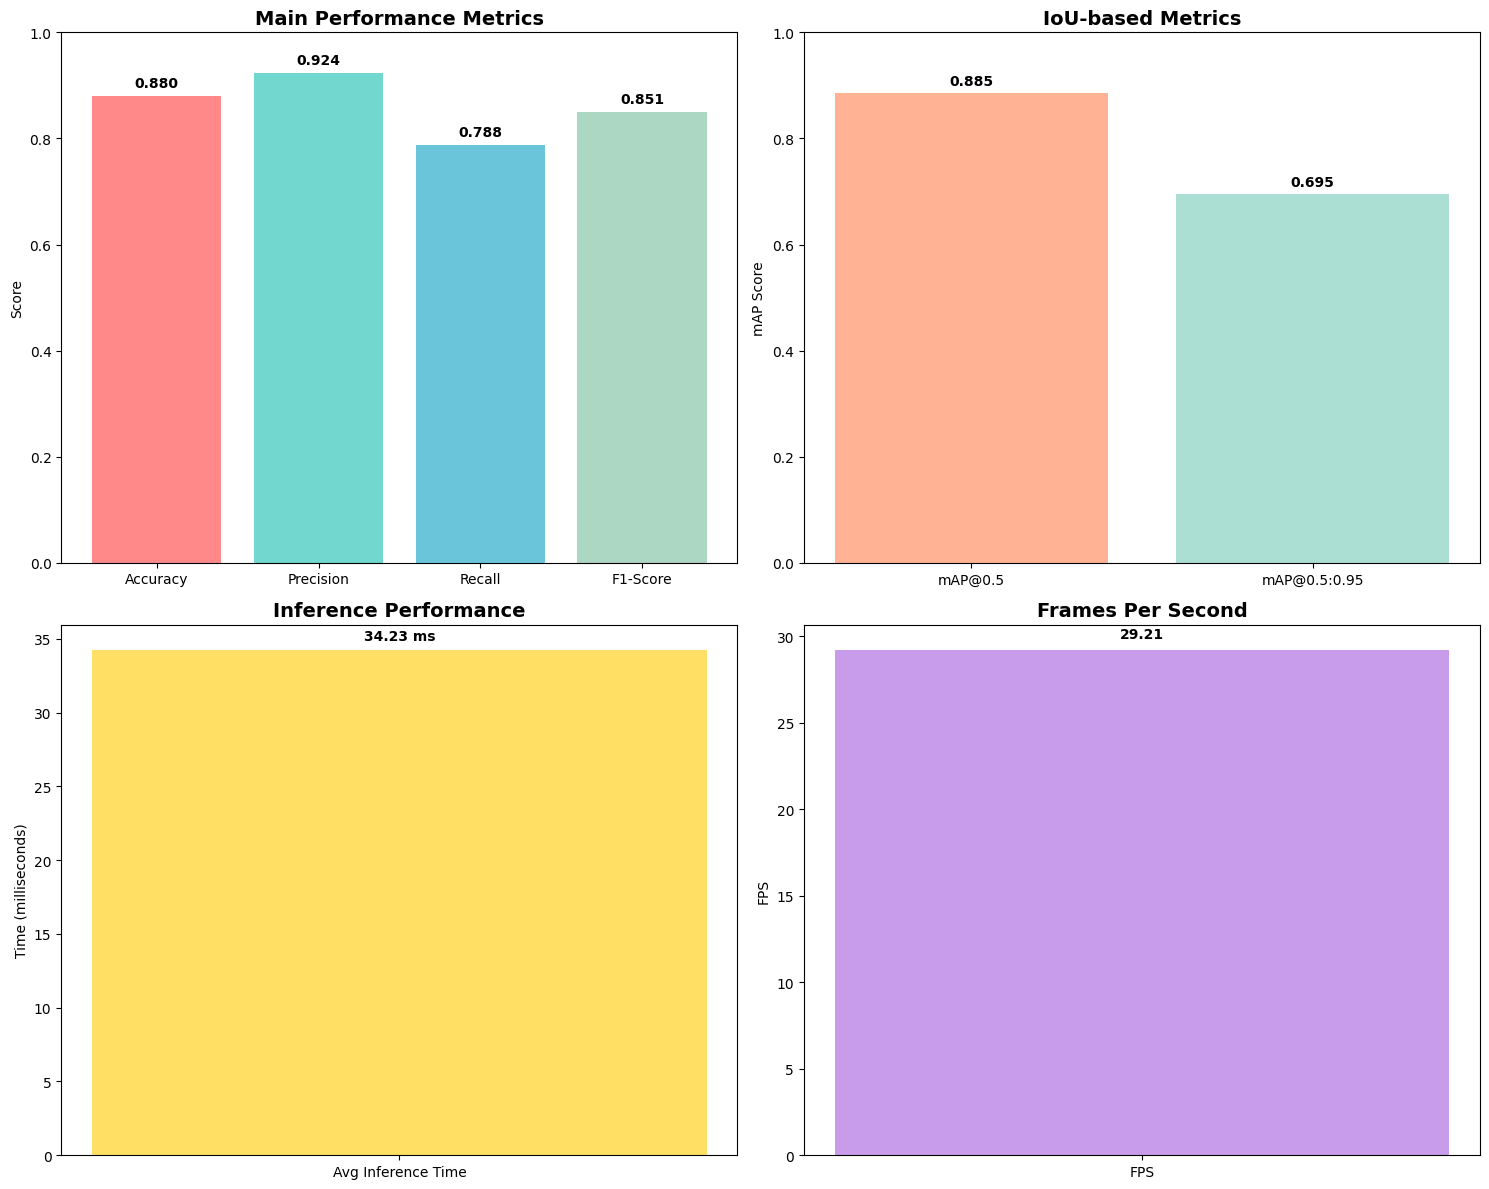

In [ ]:
def plot_evaluation_metrics(metrics):
    """Create visualization plots for evaluation metrics"""

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Main Metrics Bar Chart
    main_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    main_values = [metrics['accuracy'], metrics['precision'],
                   metrics['recall'], metrics['f1_score']]

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    bars1 = ax1.bar(main_metrics, main_values, color=colors, alpha=0.8)
    ax1.set_title('Main Performance Metrics', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Score')
    ax1.set_ylim(0, 1)

    # Add value labels on bars
    for bar, value in zip(bars1, main_values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # Plot 2: IoU Metrics
    iou_metrics = ['mAP@0.5', 'mAP@0.5:0.95']
    iou_values = [metrics['mAP50'], metrics['mAP50_95']]

    bars2 = ax2.bar(iou_metrics, iou_values, color=['#FFA07A', '#98D8C8'], alpha=0.8)
    ax2.set_title('IoU-based Metrics', fontsize=14, fontweight='bold')
    ax2.set_ylabel('mAP Score')
    ax2.set_ylim(0, 1)

    for bar, value in zip(bars2, iou_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # Plot 3: Inference Time
    ax3.bar(['Avg Inference Time'], [metrics['avg_inference_time_ms']],
            color='#FFD93D', alpha=0.8, width=0.5)
    ax3.set_title('Inference Performance', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Time (milliseconds)')
    ax3.text(0, metrics['avg_inference_time_ms'] + 0.5,
            f"{metrics['avg_inference_time_ms']:.2f} ms", ha='center', va='bottom', fontweight='bold')

    # Plot 4: FPS
    fps = 1000 / metrics['avg_inference_time_ms']
    ax4.bar(['FPS'], [fps], color='#BC83E6', alpha=0.8, width=0.5)
    ax4.set_title('Frames Per Second', fontsize=14, fontweight='bold')
    ax4.set_ylabel('FPS')
    ax4.text(0, fps + 0.5, f'{fps:.2f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig('/content/evaluation_metrics_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create visualization
if test_metrics:
    plot_evaluation_metrics(test_metrics)


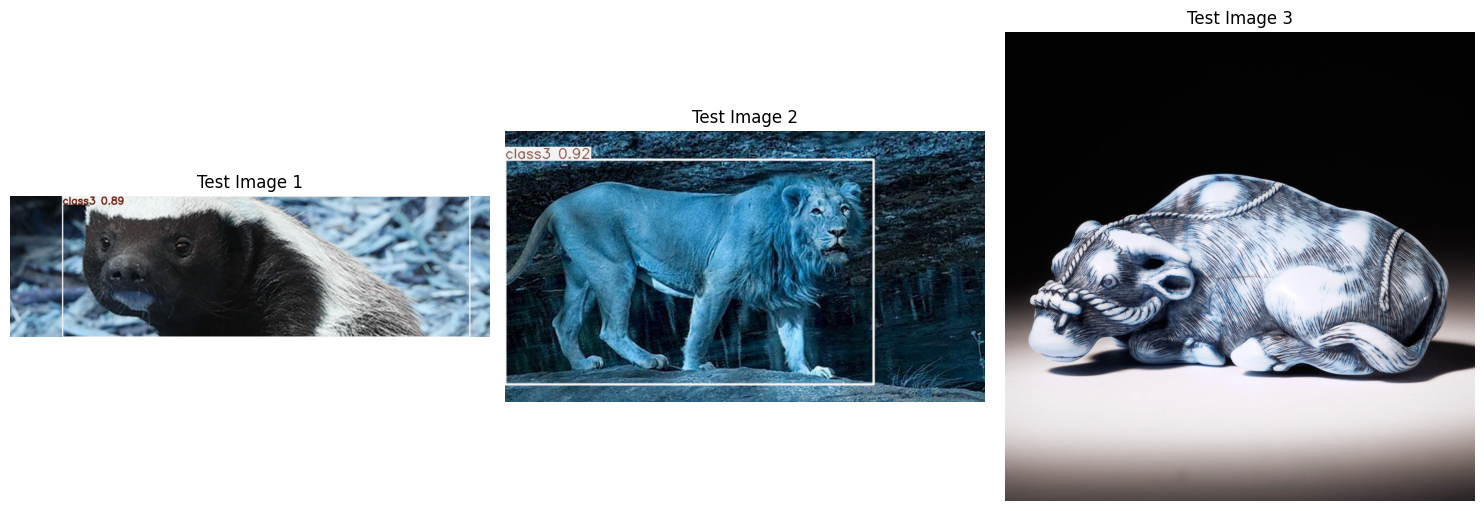

In [ ]:
def test_sample_predictions(model, test_images_path, num_samples=5):
    """Test model on sample images and display results"""

    test_images = list(Path(test_images_path).glob('*'))[:num_samples]

    if not test_images:
        print("No test images found for sample prediction!")
        return

    fig, axes = plt.subplots(1, min(len(test_images), 3), figsize=(15, 5))
    if len(test_images) == 1:
        axes = [axes]

    for i, img_path in enumerate(test_images[:3]):
        # Run inference
        results = model(str(img_path))

        # Plot results
        result_img = results[0].plot()

        if i < len(axes):
            axes[i].imshow(result_img)
            axes[i].set_title(f'Test Image {i+1}')
            axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('/content/sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

# Test on sample images
eval_img_path = eval_images_path  # Use the same evaluation path determined earlier
test_sample_predictions(model, eval_img_path)

In [ ]:
shutil.copy('/content/runs/detect/yolov11_training/weights/best.pt', '/content/best_yolov11_model.pt')
shutil.copy('/content/runs/detect/yolov11_training/weights/last.pt', '/content/last_yolov11_model.pt')

print("\n🎉 TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!")
print("📁 Files saved:")
print("   • Best model: /content/best_yolov11_model.pt")
print("   • Last model: /content/last_yolov11_model.pt")
print("   • Evaluation report: /content/evaluation_report.csv")
print("   • Metrics plot: /content/evaluation_metrics_plot.png")
print("   • Sample predictions: /content/sample_predictions.png")
print("   • Training results: /content/runs/detect/yolov11_training/")


🎉 TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!
📁 Files saved:
   • Best model: /content/best_yolov11_model.pt
   • Last model: /content/last_yolov11_model.pt
   • Evaluation report: /content/evaluation_report.csv
   • Metrics plot: /content/evaluation_metrics_plot.png
   • Sample predictions: /content/sample_predictions.png
   • Training results: /content/runs/detect/yolov11_training/


In [ ]:
# Save results back to Google Drive
def save_results_to_drive():
    """Save all results to Google Drive"""

    # Create results folder in Google Drive
    results_drive_path = '/content/drive/MyDrive/YOLOv11_Results'
    os.makedirs(results_drive_path, exist_ok=True)

    # Copy files to Google Drive
    files_to_save = [
        ('/content/best_yolov11_model.pt', 'best_yolov11_model.pt'),
        ('/content/last_yolov11_model.pt', 'last_yolov11_model.pt'),
        ('/content/evaluation_report.csv', 'evaluation_report.csv'),
        ('/content/evaluation_metrics_plot.png', 'evaluation_metrics_plot.png'),
        ('/content/sample_predictions.png', 'sample_predictions.png')
    ]

    print("💾 Saving results to Google Drive...")
    for src_path, dst_name in files_to_save:
        if os.path.exists(src_path):
            dst_path = os.path.join(results_drive_path, dst_name)
            shutil.copy(src_path, dst_path)
            print(f"   ✓ Saved {dst_name}")
        else:
            print(f"   ✗ {dst_name} not found")

    # Also copy the entire training results folder
    training_results_src = '/content/runs/detect/yolov11_training'
    training_results_dst = os.path.join(results_drive_path, 'training_results')

    if os.path.exists(training_results_src):
        shutil.copytree(training_results_src, training_results_dst)
        print(f"   ✓ Saved complete training results to Google Drive")

    print(f"\n📁 All results saved to: {results_drive_path}")
    return results_drive_path

# Save results to Google Drive
drive_results_path = save_results_to_drive()

💾 Saving results to Google Drive...
   ✓ Saved best_yolov11_model.pt
   ✓ Saved last_yolov11_model.pt
   ✓ Saved evaluation_report.csv
   ✓ Saved evaluation_metrics_plot.png
   ✓ Saved sample_predictions.png
   ✓ Saved complete training results to Google Drive

📁 All results saved to: /content/drive/MyDrive/YOLOv11_Results


In [ ]:
print(f"\n✅ All steps completed successfully!")
print(f"📁 Results saved to Google Drive: {drive_results_path}")
print(f"📁 Local results also available in: /content/runs/detect/yolov11_training/")


✅ All steps completed successfully!
📁 Results saved to Google Drive: /content/drive/MyDrive/YOLOv11_Results
📁 Local results also available in: /content/runs/detect/yolov11_training/
